In [6]:
import pandas as pd
import numpy as np
import copy
import pandapower as pp
import pandapower.networks as pn
import pandapower.plotting as plot
import pandapower.control
import pandapower.control as control
from pandapower.control import Characteristic
from pandapower.control.util.auxiliary import plot_characteristic
from datetime import date, datetime
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import json
import random
from datetime import timedelta
plt.show()

import matplotlib.pyplot as pyplt
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import psse as psse
import yaml
import folium
import copy
import datetime
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
#from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl

from grid.grid import Grid, generate_config_from_project, combine_dict, daterange

from analysis import analysis_check as ac
from analysis import capacity_analysis
from analysis import timeseries
from plotting import ppplotlytweaked as ppptw
import plotly.graph_objs as go
sys.path.insert(0,currentdir)

In [24]:
# Pandapower grid
net = pp.from_json(os.path.join(parentdir,'data\svedala_controllers_ratings.json')) 

# Dataframe over planned projects, to start this list is empty
projects = pd.DataFrame(columns=['Start', 'End', 'Object_type','ObjectID', 'Status'])

# Create grid object
svedala = Grid('Svedala',net, {}, projects)

In [25]:
svedala.grid

This pandapower network includes the following parameter tables:
   - bus (108 elements)
   - load (73 elements)
   - gen (38 elements)
   - shunt (27 elements)
   - ext_grid (1 element)
   - line (75 elements)
   - trafo (53 elements)
   - controller (38 elements)
   - bus_geodata (108 elements)
 and the following results tables:
   - res_bus (108 elements)
   - res_line (75 elements)
   - res_trafo (53 elements)
   - res_ext_grid (1 element)
   - res_load (73 elements)
   - res_shunt (27 elements)
   - res_gen (38 elements)

In [3]:
request1 = {'Start':datetime.datetime(2021,9,6), 
            'End':datetime.datetime(2021,9,7), 
            'Object_type':'line',
            'ObjectID':svedala.grid.line.name.loc[7], 
            'Status':False}
request2 = {'Start':datetime.datetime(2021,9,6), 
            'End':datetime.datetime(2021,9,7), 
            'Object_type':'line',
            'ObjectID':svedala.grid.line.name.loc[8], 
            'Status':False}
#Store project and configurations   
svedala.store_project_and_update_config(request1)
svedala.store_project_and_update_config(request2)

In [4]:
svedala.config_dict

{datetime.datetime(2021, 9, 6, 0, 0): [{'Object_type': 'line',
   'ObjectID': 'Line 7',
   'Status': False},
  {'Object_type': 'line', 'ObjectID': 'Line 8', 'Status': False}],
 datetime.datetime(2021, 9, 7, 0, 0): [{'Object_type': 'line',
   'ObjectID': 'Line 7',
   'Status': False},
  {'Object_type': 'line', 'ObjectID': 'Line 8', 'Status': False}]}

In [7]:
def daterange(start_date, end_date):
    '''
    Parameters
    ----------
    start_date: datetime.date, start date
    end_date: datetime.date, end of timeframe

    Returns generator, from start to end date, including start and end
    '''
    for n in range(-1, int((end_date - start_date).days)):
        yield start_date + timedelta(n+1)

In [8]:
start = datetime.datetime(2021, 9, 1, 0, 0)
end = datetime.datetime(2021, 9, 10, 0, 0)

In [13]:
def create_data_source(net,time_steps, list_of_names=[]):
    profiles = pd.DataFrame()
    for name in list_of_names:
        for step in time_steps:
            profiles.loc[step,name] = net.load.p_mw[net.load.name==name].values[0]*random.uniform(0,1.2)
    

    ds = DFData(profiles)

    return profiles, ds

In [14]:
def create_output_writer(net, time_steps, output_dir='timeseries_res'):
    ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".xls", log_variables=list())
    # these variables are saved to the harddisk after / during the time series loop
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_line', 'i_ka')
    ow.log_variable('shunt', 'q_mvar')
    return ow

In [15]:
#pp load controller
def create_controllers(net, ds):
    for idx, row in net.load.iterrows():
        ConstControl(net, element='load', variable='p_mw', element_index=[idx],
                    data_source=ds, profile_name=row['name'])

In [16]:
import importlib
importlib.reload(timeseries)

<module 'analysis.timeseries' from 'C:\\Users\\DDDSOadmin\\Desktop\\capacity\\capacity-map\\analysis\\timeseries.py'>

In [17]:
# time steps to be calculated. Could also be a list with non-consecutive time steps
datetime_steps= list(daterange(start,end))
time_steps = range(0, len(datetime_steps))

In [18]:
# 2. create (random) data source
profiles, ds = create_data_source(svedala.grid,time_steps,list_of_names=svedala.grid.load.name)
n_timesteps = len(profiles)

In [19]:
# 3. create controllers (to control P values of the load and the sgen)
create_controllers(svedala.grid, ds)

In [14]:
# 4. the output writer with the desired results to be stored to files.
ow = create_output_writer(svedala.grid, time_steps)

# 5. the main time series function
timeseries.run_timeseries(svedala, time_steps, datetime_steps, continue_on_divergence=True)

Progress: |██████████████████████████████████████████████████| 100.0% Complete



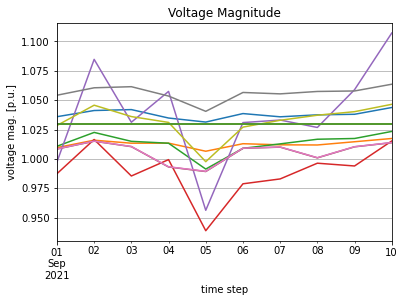

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline  

# voltage results
output_dir = 'timeseries_res'
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xls")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)
vm_pu.index = datetime_steps
vm_pu.plot(legend=False)
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

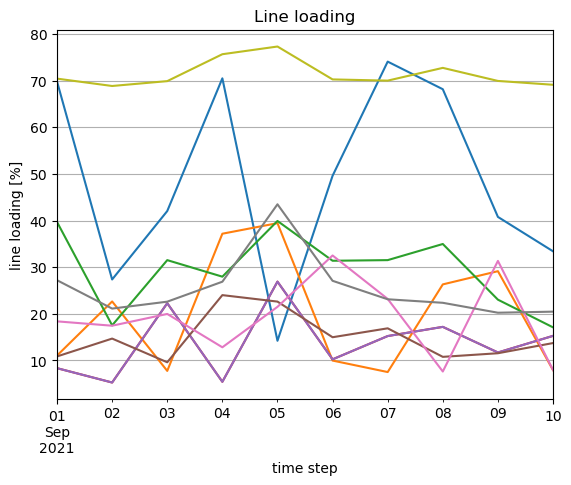

In [21]:
# voltage results
output_dir = 'timeseries_res'
line_loading_file = os.path.join(output_dir, "res_line", "loading_percent.xls")
line_loading = pd.read_excel(line_loading_file, index_col=0)
line_loading.index = datetime_steps
line_loading.plot(legend=False)
plt.xlabel("time step")
plt.ylabel("line loading [%]")
plt.title("Line loading")
plt.grid()
plt.show()

This pandapower network includes the following parameter tables:
   - bus (108 elements)
   - load (73 elements)
   - gen (38 elements)
   - shunt (27 elements)
   - ext_grid (1 element)
   - line (75 elements)
   - trafo (53 elements)
   - controller (111 elements)
   - bus_geodata (108 elements)
 and the following results tables:
   - res_bus (108 elements)
   - res_line (75 elements)
   - res_trafo (53 elements)
   - res_ext_grid (1 element)
   - res_load (73 elements)
   - res_shunt (27 elements)
   - res_gen (38 elements)

In [55]:
create_controllers(svedala.grid,ds)

In [153]:
svedala.grid.output_writer

,object
0,OutputWriter: writes output to 'timeseries_res...
